In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'




In [2]:
model="chair"
dataset= "../nerf_synthetic/" + model
focal, all_c2w, all_gt = get_data(dataset, "train")

LOAD DATA ../nerf_synthetic/chair/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 49.79it/s]


In [3]:
back_focal, back_c2w, back_gt = get_data(dataset, "train", True)

LOAD DATA ../nerf_synthetic/chair/train


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 81.64it/s]


In [4]:
red = 4
target_ims_carve, rays_carve = reduce_data(back_c2w, back_gt.squeeze(), back_focal, red)
print(red)
red = 4
target_ims, rays = reduce_data(all_c2w, all_gt, focal, red)
print(red)
red = 2
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
print(red)

4
4
2


In [5]:
D_carve = RayDataset(target_ims_carve, rays_carve, device)
train_loader_carve = torch.utils.data.DataLoader(D_carve, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


In [26]:
VG = VoxelGridCarve(128, 1.4, 20)

In [15]:


def carve(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1)
        grid.carve((rays[0][mask],rays[1][mask]) , N_points)

def color(grid, loader, N_points):
    for batch_idx, (rays, pixels) in enumerate(tqdm(loader)):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        mask = (pixels==1).all(1)
        mask = torch.logical_not(mask)
        grid.color((rays[0][mask],rays[1][mask]), pixels[mask], N_points)
    with torch.no_grad():
        mask = VG.colors_sum>0
        VG.colors[mask] = VG.colors[mask]/(VG.colors_sum[mask, None])
 


In [16]:
N_points = 900
10*1.1/1.2/(N_points-1), 2*VG.bound_w/VG.size

(0.010196514645902856, 0.021875)

100%|█████████████████████████████████████████| 800/800 [00:32<00:00, 24.29it/s]


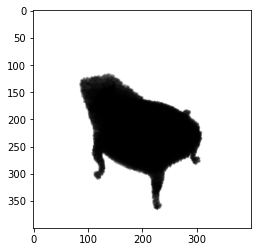

In [27]:
carve(VG, train_loader_carve, N_points)
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

In [10]:
D = RayDataset(target_ims, rays, device)
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


100%|█████████████████████████████████████████| 800/800 [00:26<00:00, 29.70it/s]


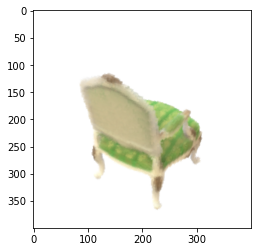

In [28]:
color(VG, train_loader, N_points)
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(N_points,1.2)))
plt.show()

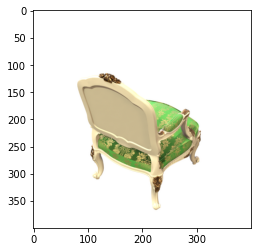

In [29]:
plt.imshow(disp_ims[30])
plt.show()

In [31]:
VG.save('chair_carve3.obj')

In [ ]:
with torch.no_grad():
    VG.opacities[:] *= 2

In [15]:
class Voxel_dev(VoxelGridCarve):
    def render_rays(self, ordir_tuple, N_points, inv_depth=1.2):
        ori = ordir_tuple[0][:, None,:]
        
        # WARNING: Assuming constant distance
        distances = 10*torch.sqrt( (ordir_tuple[1]**2).sum(1, keepdim=True))/inv_depth/(N_points-1)
        scatter_points = torch.rand_like(distances)*distances + torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth

        p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])        
        with torch.no_grad():
            # extract valid indices
            inds_3d = torch.round(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0
        
        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]*in_bounds.float() # not_in bounds: 0 opacity
        
        opacities = opacities*distances
        
        cumsum_opacities = torch.zeros_like(opacities, device=device)
        cumsum_opacities[:,1:] = torch.cumsum(opacities[:,:-1], 1)
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        #print(torch.exp(-cumsum_opacities))
        
        return (colors*transp_term[..., None]).sum(1) + torch.exp(-cumsum_opacities[:, -1])[..., None]

In [16]:
m  =torch.rand(4)
m, torch.cumsum(m, 0)

(tensor([0.6079, 0.0229, 0.1011, 0.6207]),
 tensor([0.6079, 0.6309, 0.7320, 1.3527]))

In [17]:
VG = Voxel_dev(64, 1.4, 40)
VG.load('drums_carve.obj')

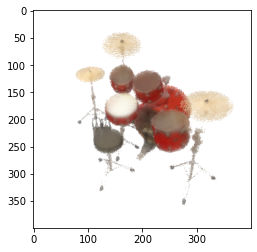

In [18]:
plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(200,1.2)))
plt.show()

In [87]:
s.max()

tensor(4.6075, device='cuda:0', grad_fn=<MaxBackward1>)

In [94]:
disp_ims[20][disp_ims[20]!=1].shape

(101209,)

In [102]:
np.array(disp_ims).shape

(100, 400, 400, 3)

(array([4.42000e+02, 1.06320e+04, 1.36384e+05, 3.65568e+05, 5.57379e+05,
        5.22671e+05, 6.58256e+05, 5.63838e+05, 2.40989e+05, 3.20571e+05]),
 array([0.        , 0.09986945, 0.1997389 , 0.29960836, 0.39947781,
        0.49934726, 0.59921671, 0.69908617, 0.79895562, 0.89882507,
        0.99869452]),
 <BarContainer object of 10 artists>)

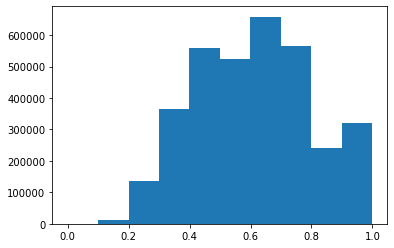

In [103]:
s = np.sqrt((np.array(disp_ims)**2).sum(3)/3).flatten()
s = s[s!=1]
plt.hist(s.tolist())

(array([1.000e+00, 0.000e+00, 4.000e+00, 6.370e+02, 2.496e+03, 1.902e+03,
        9.900e+02, 3.940e+02, 1.920e+02, 1.390e+02]),
 array([0.01694555, 0.115251  , 0.21355644, 0.31186189, 0.41016733,
        0.50847278, 0.60677822, 0.70508367, 0.80338911, 0.90169456,
        1.        ]),
 <BarContainer object of 10 artists>)

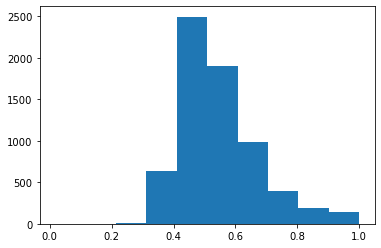

In [104]:
VG.clamp()
s = torch.sqrt((VG.colors[VG.opacities!=0]**2).sum(1)/3)
plt.hist(s.tolist())

In [119]:
out = VG.make_palette(9)

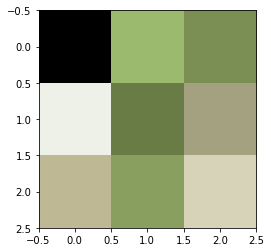

In [120]:
plt.imshow(out[1][..., :3].reshape(3,3,3))



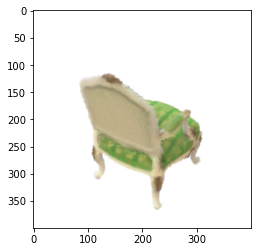

In [35]:

plt.imshow(VG.render_large_image_from_rays(disp_rays[30],(3000,1.2)))
plt.show()

In [61]:


def train(model, epoch, optimizer, N_points):
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        rays, pixels = (rays[0].to(device),rays[1].to(device)), pixels.to(device)
        optimizer.zero_grad()
        pix_estims = model.render_rays(rays, N_points)
        loss = ((pix_estims-pixels)**2).sum()/rays[0].shape[0] + 0.0001*VG.total_variation()
        loss.backward()
        losses.append(loss.item())
        mask = (model.opacities==0)
        optimizer.step()
        model.clamp()
        with torch.no_grad():
            model.opacities[mask]=0
        if batch_idx%10==0:
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        100.0 * batch_idx / len(train_loader),
                        loss.data.item(),
                    ),
                    flush = True
                )
    return losses

losses=[]

In [ ]:
VG2 = VG.copy()
VG2.save('chair_carve.obj')
VG2.save_pointcloud()

  0%|                                                     | 0/4 [00:00<?, ?it/s]

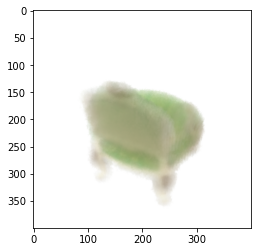

Train Epoch: 0 [0/200 (0%)]	Loss: 0.027190
Train Epoch: 0 [10/200 (5%)]	Loss: 0.024498
Train Epoch: 0 [20/200 (10%)]	Loss: 0.023971
Train Epoch: 0 [30/200 (15%)]	Loss: 0.025065
Train Epoch: 0 [40/200 (20%)]	Loss: 0.025152
Train Epoch: 0 [50/200 (25%)]	Loss: 0.024821
Train Epoch: 0 [60/200 (30%)]	Loss: 0.023501
Train Epoch: 0 [70/200 (35%)]	Loss: 0.023713
Train Epoch: 0 [80/200 (40%)]	Loss: 0.021292
Train Epoch: 0 [90/200 (45%)]	Loss: 0.023711
Train Epoch: 0 [100/200 (50%)]	Loss: 0.022930
Train Epoch: 0 [110/200 (55%)]	Loss: 0.022979


  0%|                                                     | 0/4 [02:22<?, ?it/s]


KeyboardInterrupt: 

In [69]:
epochss = [4]
N_pointss = [200]
lrs = [100000]



for epochs, N_points, lr in zip(epochss,N_pointss, lrs):
    opt_c= torch.optim.SGD(
                [VG.opacities], 
                lr=lr
            )

   
    for epoch in tqdm(range(epochs)):
        #VG.save("some.obj")
        plt.imshow(VG.render_large_image_from_rays(disp_rays[0],(500,1.2)))
        plt.show()
        losses += train(VG, epoch, opt_c, N_points)
        plt.plot(np.log(rolling_average(np.array(losses))))
        plt.show()




In [21]:
VG.save_pointcloud()


In [44]:
train_loader = torch.utils.data.DataLoader(D, batch_size=5000, shuffle=True)